In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
import torch
from tqdm.autonotebook import tqdm
import os
import numpy as np

In [2]:
# processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# model = AutoModel.from_pretrained(
#     "facebook/dinov2-base",
#     torch_dtype=torch.float16,
# ).to("cuda")

In [10]:
def get_voc_names_and_classes(task_and_ov):
    base_path = "/home/thesis/marx/wilson_gen/WILSON/data/voc/JPEGImages/"
    voc_names = []
    voc_classes = []
    with open(f"voc_lora_{task_and_ov}/train/metadata.csv", "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            line = line.strip()
            voc_names.append(base_path + line.split(",")[0])
            voc_classes.append(line.split(",")[1].split(" ")[-1])
    return voc_names, voc_classes

def get_gen_names_and_classes(gen_dir, task_and_ov):
    base_path = f"/home/thesis/marx/wilson_gen/WILSON/{gen_dir}/{task_and_ov}"
    gen_names = []
    gen_classes = []
    for cl_dir in os.listdir(base_path):
        if os.path.isdir(f"{base_path}/{cl_dir}"):
            for img in os.listdir(f"{base_path}/{cl_dir}/images"):
                gen_names.append(f"{base_path}/{cl_dir}/images/{img}")
                gen_classes.append(cl_dir)
    return gen_names, gen_classes

def get_embeds(model, processor, image_names):
    with torch.no_grad():
        images = [Image.open(img_name).convert("RGB") for img_name in image_names]
        inputs = processor(images=images, return_tensors="pt")
        outputs = model(**inputs.to("cuda"))
        last_hidden_states = outputs.last_hidden_state
        return last_hidden_states.mean(dim=1).cpu().numpy()

def get_embeddings(dataset_name, task_and_ov, model, processor, batch_size):
    if os.path.exists(f"dino_embeds/{dataset_name}/{task_and_ov}"):
        embeddings = {cl[:-4]: np.load(f"dino_embeds/{dataset_name}/{task_and_ov}/{cl[:-4]}.npy") for cl in sorted(os.listdir(f"dino_embeds/{dataset_name}/{task_and_ov}"))}
    else:
        if dataset_name == "voc":
            names, classes = get_voc_names_and_classes(task_and_ov)
        else:
            names, classes = get_gen_names_and_classes(dataset_name, task_and_ov)
        embeddings = {cl: [] for cl in np.unique(classes)}
        for i in tqdm(range(0, len(names), batch_size)):
            embeds = get_embeds(model, processor, names[i:i+batch_size])
            for emb, cl in zip(embeds, classes[i:i+batch_size]):
                embeddings[cl].append(emb)
        os.makedirs(f"dino_embeds/{dataset_name}/{task_and_ov}", exist_ok=True)
        for cl, embeds in embeddings.items():
            np.save(f"dino_embeds/{dataset_name}/{task_and_ov}/{cl}.npy", np.array(embeds))
        embeddings = {cl: np.array(embeddings[cl]) for cl in embeddings}
    return embeddings

def get_cossim(voc_embeddings, gen_embeddings):
    voc_embeddings_normed = voc_embeddings / np.linalg.norm(voc_embeddings, axis=1)[:, np.newaxis]
    gen_embeddings_normed = gen_embeddings / np.linalg.norm(gen_embeddings, axis=1)[:, np.newaxis]
    return np.matmul(voc_embeddings_normed, gen_embeddings_normed.T)

def get_similarities(voc_embedding_dict, gen_embedding_dict):
    sims = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    sim_stds = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    for cl in list(voc_embedding_dict.keys()):
        cossim_mat = get_cossim(voc_embedding_dict[cl], gen_embedding_dict[cl])
        sims[cl] = cossim_mat.mean()
        sim_stds[cl] = cossim_mat.mean(axis=0).std() / np.sqrt(cossim_mat.shape[1])
    return sims, sim_stds

def get_similarities_top_k(voc_embedding_dict, gen_embedding_dict, k):
    sims = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    sim_stds = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    for cl in list(voc_embedding_dict.keys()):
        cossim_mat = get_cossim(voc_embedding_dict[cl], gen_embedding_dict[cl])
        # get top k similarities for each gen image
        cossim_mat = np.sort(cossim_mat, axis=0)[::-1][:k]
        sims[cl] = cossim_mat.mean()
        sim_stds[cl] = cossim_mat.mean(axis=0).std() / np.sqrt(cossim_mat.shape[1])
    return sims, sim_stds

def get_similarities_last_k(voc_embedding_dict, gen_embedding_dict, k):
    sims = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    sim_stds = {cl: 0 for cl in list(voc_embedding_dict.keys())}
    for cl in list(voc_embedding_dict.keys()):
        cossim_mat = get_cossim(voc_embedding_dict[cl], gen_embedding_dict[cl])
        # get top k similarities for each gen image
        cossim_mat = np.sort(cossim_mat, axis=0)[:k]
        sims[cl] = cossim_mat.mean()
        sim_stds[cl] = cossim_mat.mean(axis=0).std() / np.sqrt(cossim_mat.shape[1])
    return sims, sim_stds

In [4]:
# When using presaved embeddings
model = None
processor = None

In [5]:
voc_embeddings = get_embeddings("voc", "10-10", model, processor, batch_size=16)
voc_embeddings_ov = get_embeddings("voc", "10-10-ov", model, processor, batch_size=16)


In [6]:
replay_sets = [
    "voc",
    "replay_data_baseline",
    "replay_data_mrte",
    "replay_data_cap",
    "replay_data_better_cap",
    "replay_data_lora"
]

In [11]:
def get_all(k=None, verbose=False):
    if k is None:
        all_cossims = {}
        all_stds = {}
        for replay_set in replay_sets:
            embeds = get_embeddings(replay_set, "10-10", model, processor, batch_size=16)
            embeds_ov = get_embeddings(replay_set, "10-10-ov", model, processor, batch_size=16)
            sims, stds = get_similarities(voc_embeddings, embeds)
            sims_ov, stds_ov = get_similarities(voc_embeddings_ov, embeds_ov)
            sims["mean"] = np.mean(list(sims.values()))
            sims_ov["mean"] = np.mean(list(sims_ov.values()))
            stds["mean"] = np.sqrt(np.array(list(stds.values()))**2).mean()
            stds_ov["mean"] = np.sqrt(np.array(list(stds_ov.values()))**2).mean()
            all_cossims[replay_set] = {"dj": sims, "ov": sims_ov}
            all_stds[replay_set] = {"dj": stds, "ov": stds_ov}
            if verbose:
                print(replay_set)
                print(f"    class: dj_sims, ov_sims")
                for cl in sims:
                    print(f"    {cl}: {sims[cl]}, {sims_ov[cl]}")
                # print(f"    mean: {np.mean(list(sims.values()))}, {np.mean(list(sims_ov.values()))}")
                print("==================================================")
        return all_cossims, all_stds
    elif k > 0:
        all_cossims = {}
        all_stds = {}
        for replay_set in replay_sets:
            embeds = get_embeddings(replay_set, "10-10", model, processor, batch_size=16)
            embeds_ov = get_embeddings(replay_set, "10-10-ov", model, processor, batch_size=16)
            sims, stds = get_similarities_top_k(voc_embeddings, embeds, k)
            sims_ov, stds_ov = get_similarities_top_k(voc_embeddings_ov, embeds_ov, k)
            sims["mean"] = np.mean(list(sims.values()))
            sims_ov["mean"] = np.mean(list(sims_ov.values()))
            stds["mean"] = np.sqrt(np.array(list(stds.values()))**2).mean()
            stds_ov["mean"] = np.sqrt(np.array(list(stds_ov.values()))**2).mean()
            all_cossims[replay_set] = {"dj": sims, "ov": sims_ov}
            all_stds[replay_set] = {"dj": stds, "ov": stds_ov}
            if verbose:
                print(replay_set)
                print(f"    class: dj_sims, ov_sims")
                for cl in sims:
                    print(f"    {cl}: {sims[cl]}, {sims_ov[cl]}")
                # print(f"    mean: {np.mean(list(sims.values()))}, {np.mean(list(sims_ov.values()))}")
                print("==================================================")
        return all_cossims, all_stds
    else:
        all_cossims = {}
        all_stds = {}
        for replay_set in replay_sets:
            embeds = get_embeddings(replay_set, "10-10", model, processor, batch_size=16)
            embeds_ov = get_embeddings(replay_set, "10-10-ov", model, processor, batch_size=16)
            sims, stds = get_similarities_last_k(voc_embeddings, embeds, k)
            sims_ov, stds_ov = get_similarities_last_k(voc_embeddings_ov, embeds_ov, k)
            sims["mean"] = np.mean(list(sims.values()))
            sims_ov["mean"] = np.mean(list(sims_ov.values()))
            stds["mean"] = np.sqrt(np.array(list(stds.values()))**2).mean()
            stds_ov["mean"] = np.sqrt(np.array(list(stds_ov.values()))**2).mean()
            all_cossims[replay_set] = {"dj": sims, "ov": sims_ov}
            all_stds[replay_set] = {"dj": stds, "ov": stds_ov}
            if verbose:
                print(replay_set)
                print(f"    class: dj_sims, ov_sims")
                for cl in sims:
                    print(f"    {cl}: {sims[cl]}, {sims_ov[cl]}")
                # print(f"    mean: {np.mean(list(sims.values()))}, {np.mean(list(sims_ov.values()))}")
                print("==================================================")
        return all_cossims, all_stds

In [12]:
def plot_cossims(all_cossims, all_stds, k=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for replay_set in replay_sets:
        if replay_set == "voc":
            axes[0].errorbar(
                list(all_cossims[replay_set]["dj"].keys()),
                list(all_cossims[replay_set]["dj"].values()),
                yerr=list(all_stds[replay_set]["dj"].values()),
                label=replay_set,
                color="k"
            )
            axes[1].errorbar(
                list(all_cossims[replay_set]["ov"].keys()),
                list(all_cossims[replay_set]["ov"].values()),
                yerr=list(all_stds[replay_set]["ov"].values()),
                label=replay_set,
                color="k"
            )
        else:
            axes[0].errorbar(
                list(all_cossims[replay_set]["dj"].keys()),
                list(all_cossims[replay_set]["dj"].values()),
                yerr=list(all_stds[replay_set]["dj"].values()),
                label=replay_set
            )
            axes[1].errorbar(
                list(all_cossims[replay_set]["ov"].keys()),
                list(all_cossims[replay_set]["ov"].values()),
                yerr=list(all_stds[replay_set]["ov"].values()),
                label=replay_set
            )
    axes[0].set_title("Disjoint")
    axes[0].set_xlabel("class")
    axes[0].set_ylabel("cossim")
    axes[0].tick_params(axis='x', labelrotation=90)
    # axes[0].legend()
    axes[1].set_title("Overlap")
    axes[1].set_xlabel("class")
    axes[1].set_ylabel("cossim")
    axes[1].tick_params(axis='x', labelrotation=90)
    axes[1].legend(bbox_to_anchor=(1.01, 1.02))
    plt.tight_layout()
    if k is not None:
        if k > 0:
            fig.text(0.5, 0.01, f"cossims for top {k} best fits", ha='center')
        else:
            fig.text(0.5, 0.01, f"cossims for top {-k} worst fits", ha='center')
    plt.show()

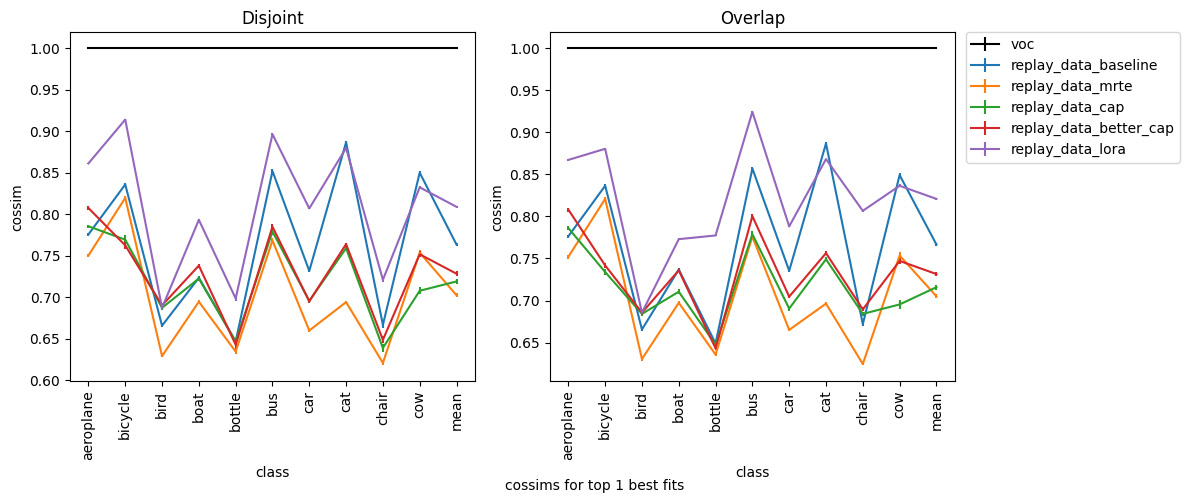

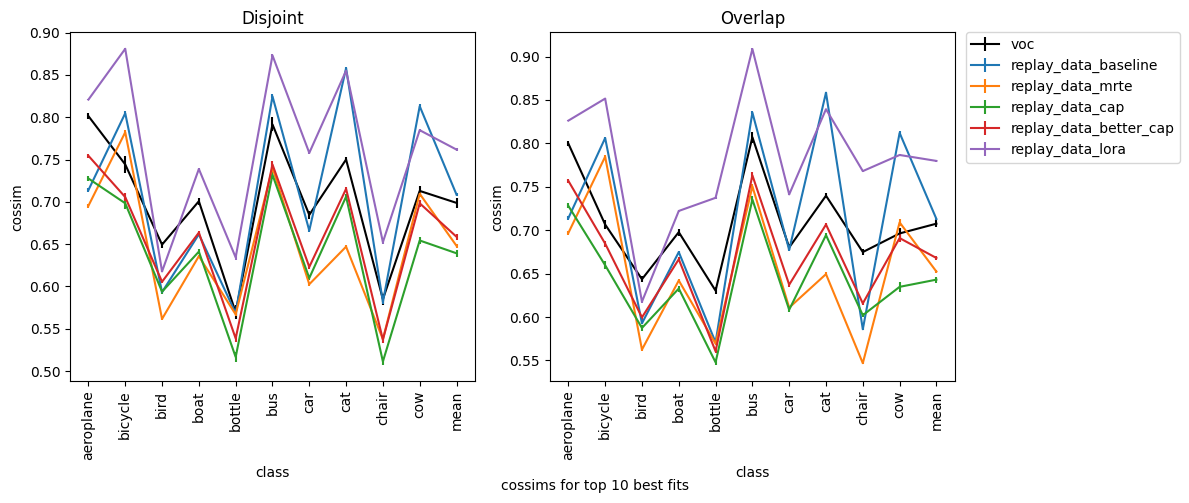

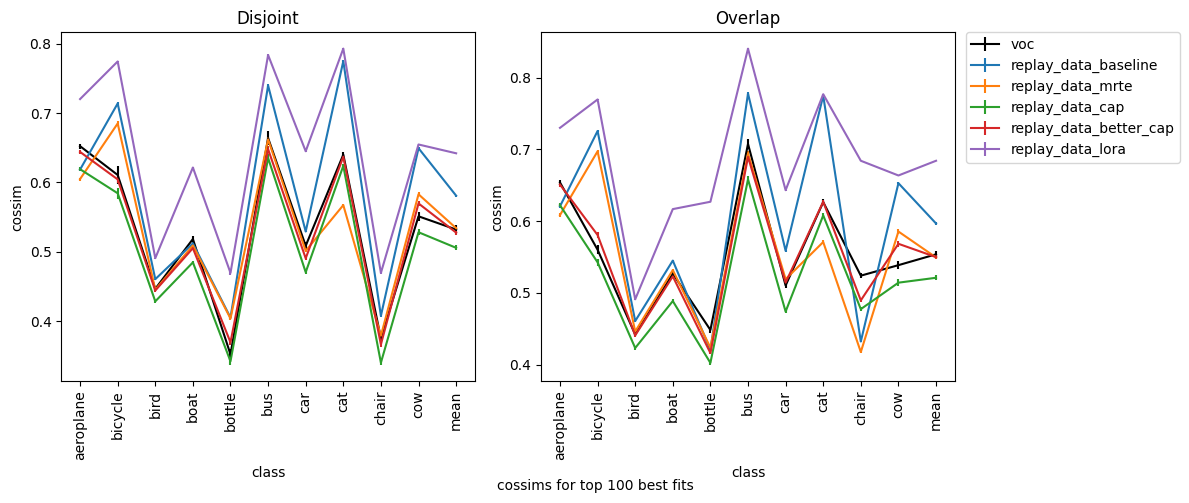

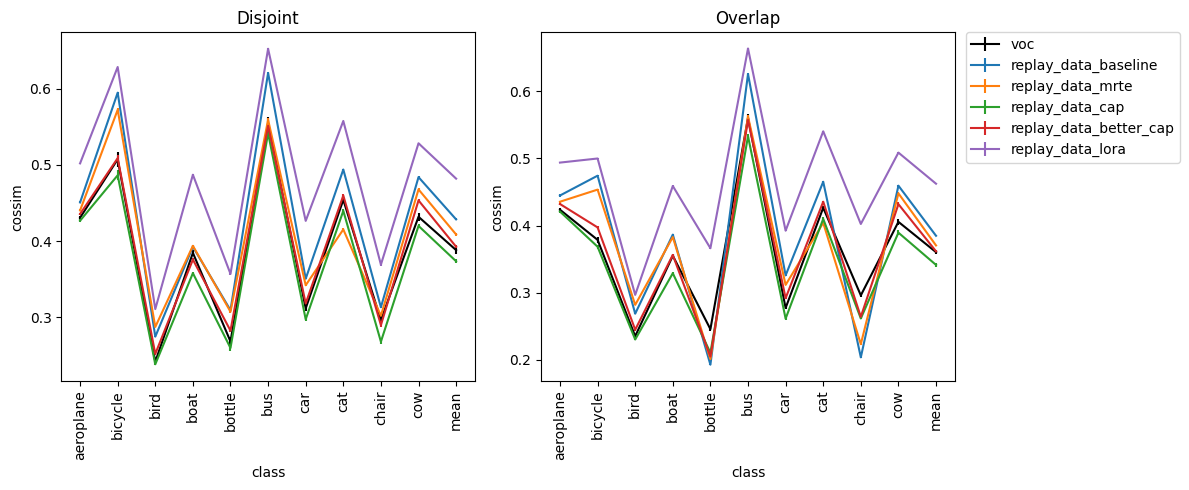

In [9]:
for k in [1, 10, 100, None]:
    all_cossims, all_stds = get_all(k=k)
    plot_cossims(all_cossims, all_stds, k=k)

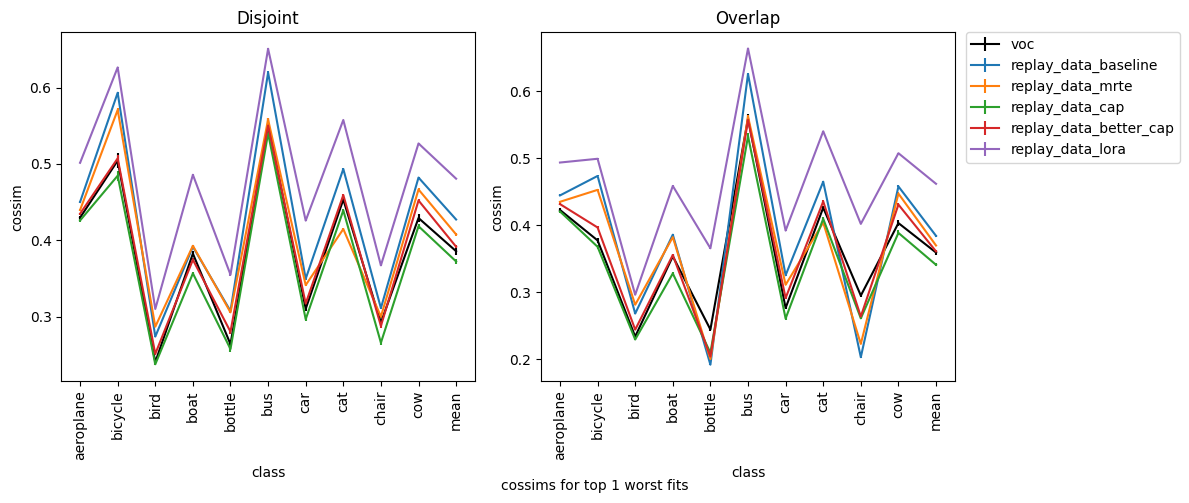

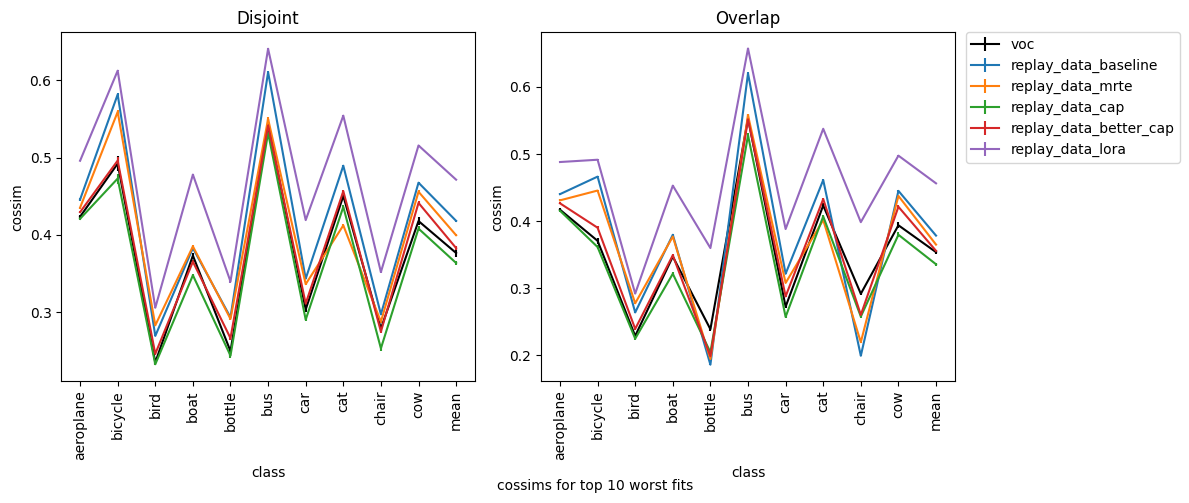

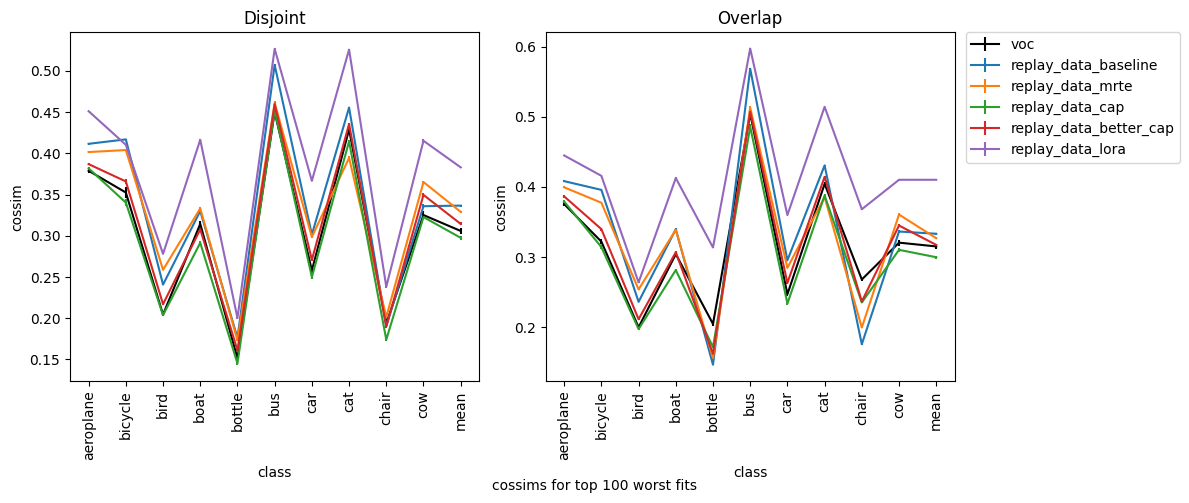

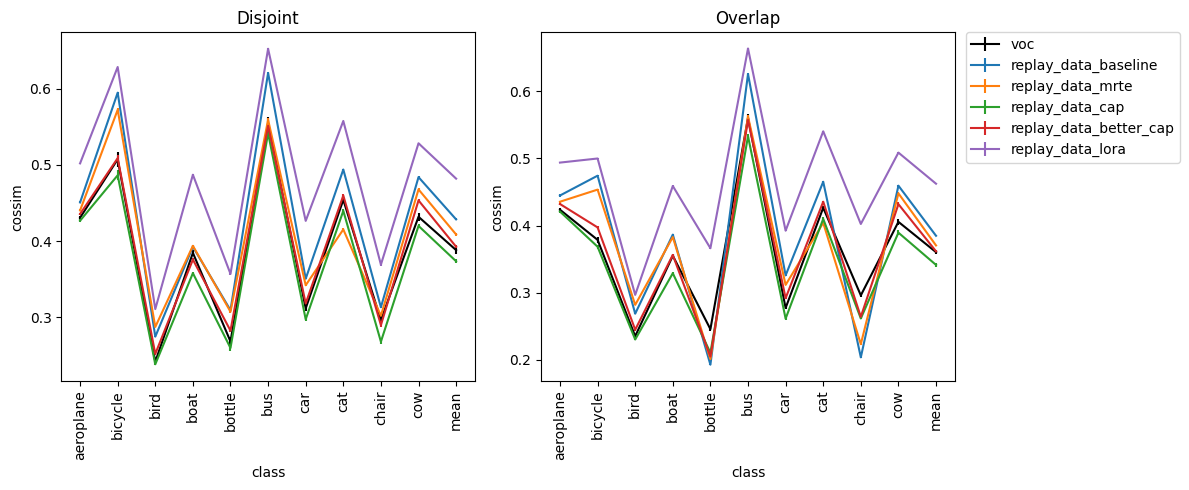

In [13]:
for k in [-1, -10, -100, None]:
    all_cossims, all_stds = get_all(k=k)
    plot_cossims(all_cossims, all_stds, k=k)